In [1]:
import glob
import json
import os
import uuid

from dotenv import load_dotenv
import numpy as np
from PIL import Image

import torch

import matplotlib.pyplot as plt

from koger_detection.obj_det.predictors import Predictor
from koger_detection.obj_det.mydatasets import ImageDataset
from koger_detection.obj_det.engine import collate_fn, worker_init_fn

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.17 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
# Assumes we have a local .env file that stores things like ROOT
load_dotenv()

research_project = "high-elevation"
model_run = "10-02-2024-16-30-43"

model_root = os.environ.get("MODEL_PATH")
model_folder = os.path.join(model_root, research_project, "runs", model_run)
model_cfg_file = os.path.join(model_folder, "cfg.json")
model_weights_file = os.path.join(model_folder, "final_model.pth")

root = os.environ.get("ROOT")
image_folder = os.path.join(root, "annotations", research_project, "images")
image_files = sorted(glob.glob(os.path.join(image_folder, f"*.[j,J][pP][gG]")))

In [3]:
with open(model_cfg_file) as f:
    cfg = json.load(f)
    model_cfg = cfg['model']
model_cfg['model_weights_pth'] = model_weights_file

In [4]:
image_dataset = ImageDataset(image_files, rgb=True)
dataloader = torch.utils.data.DataLoader(
            image_dataset, batch_size=1, shuffle=False, 
            num_workers=4)

predictor = Predictor(model_cfg, invert_color_channel=False)

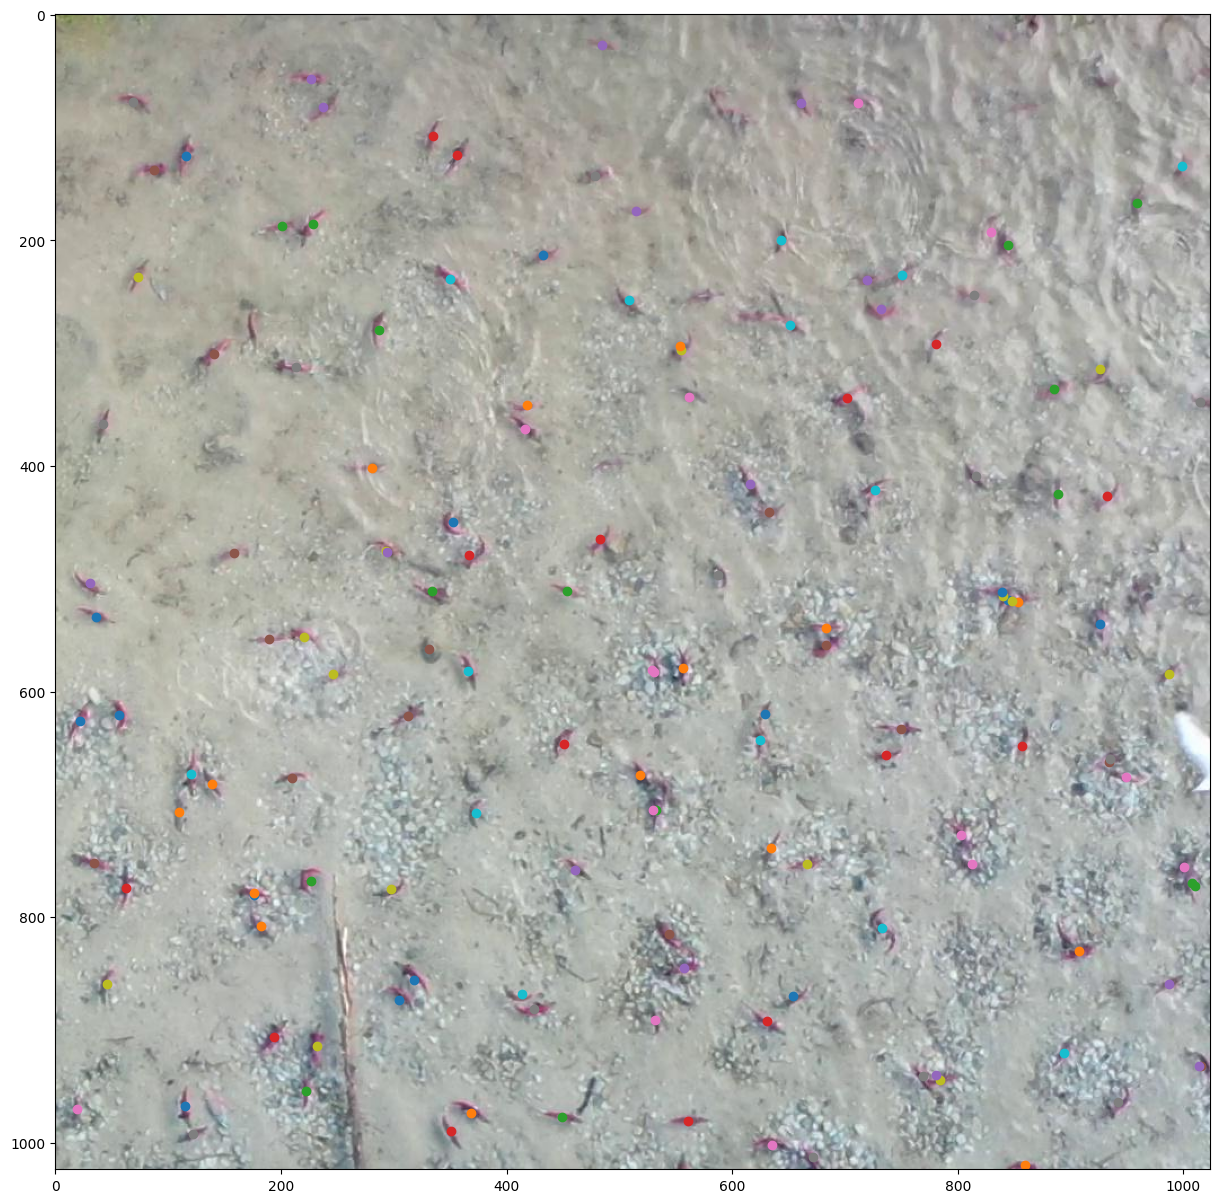

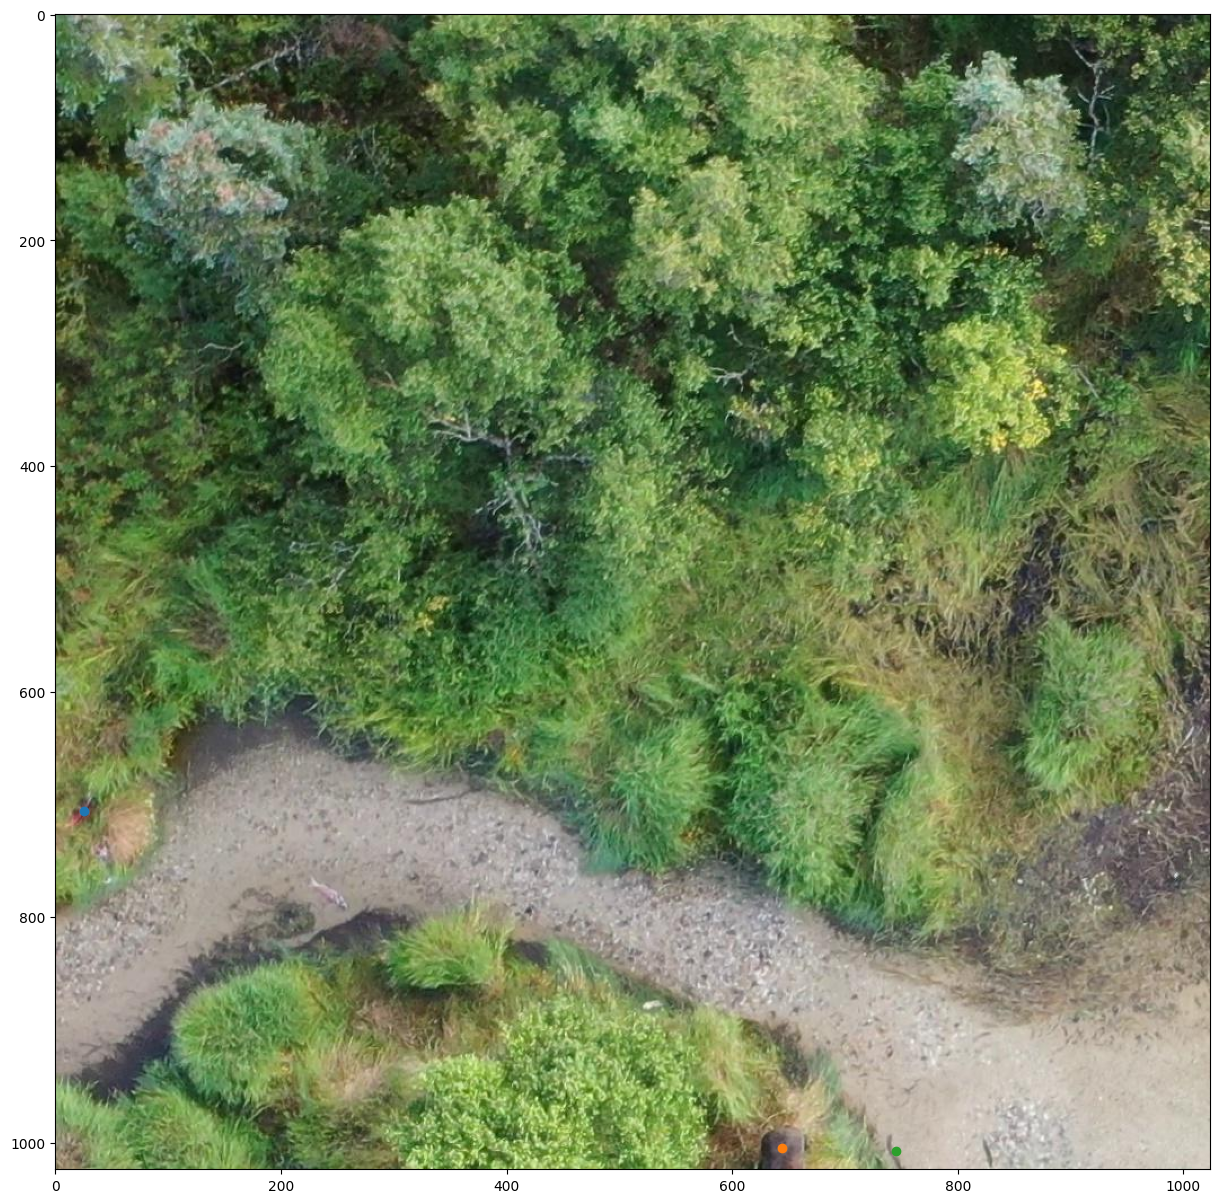

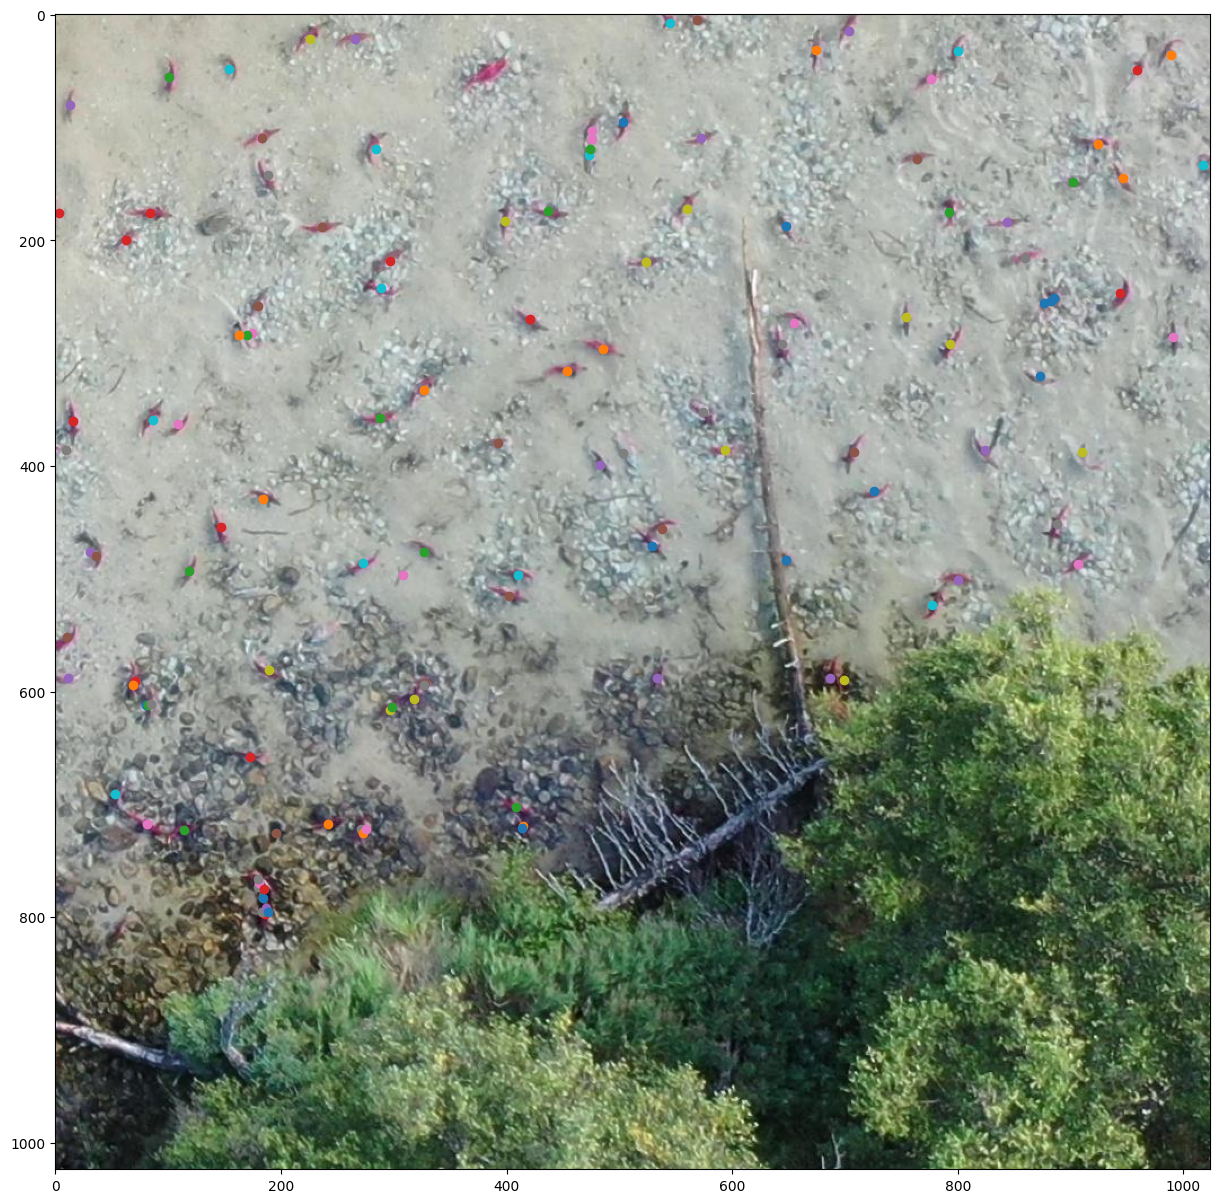

In [6]:
output_folder = os.path.join(root, research_project, "output")
os.makedirs(output_folder, exist_ok=True)
for image_ind, image in enumerate(dataloader):
    res = predictor(image['image'][0])
    
    boxes = res['boxes'].to('cpu').numpy().astype(np.uint32)
    scores = res['scores'].to('cpu').numpy()

    image_name = os.path.splitext(os.path.basename(image['filename'][0]))[0]

    np.save(os.path.join(output_folder, f"{image_name}_boxes.npy"), boxes)
    np.save(os.path.join(output_folder, f"{image_name}_scores.npy"), scores)
    
    plt.figure(figsize=(15,15))
    # Convert to rgb
    plt.imshow(image['image'][0])
    
    num_drawn = 0
    
    for box, score in zip(boxes, scores):
        if score < .5:
            continue
        x = np.mean([box[0], box[2]])
        y = np.mean([box[1], box[3]])
        plt.scatter(x, y, alpha=1.0)
        num_drawn += 1
    # plt.axis('off')
    # print(num_drawn)
    # fname = os.path.join("/home/koger/Dropbox/UWWRF/detection/high-altitude/media",
    #                      "DJI_0874_full.jpg")
    # plt.savefig(fname, dpi=300, bbox_inches='tight')
    if image_ind >= 2:
        break
